## Import data

In [79]:
import pandas

In [81]:
accidents = pandas.read_csv("../datasets/project/road safety/road-safety-data-accidents-2016.csv")
casualties = pandas.read_csv("../datasets/project/road safety/road-safety-data-casualties-2016.csv")
vehicles = pandas.read_csv("../datasets/project/road safety/road-safety-data-vehicles-2016.csv")

In [195]:
accidents.columns.values

array(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area',
       'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'], dtype=object)

## Plot data

In [83]:
import folium

In [84]:
# https://stackoverflow.com/questions/42756934/how-to-plot-lat-and-long-from-pandas-dataframe-on-folium-map-group-by-some-label
# Map centered at Dundee (or, where Google tells me Dundee is...)
colors = {'Slight': 'green', 'Serious': 'orange', 'Fatal': 'red'}
map_osm = folium.Map(location=[56.4620, -2.9707], zoom_start=12)
accidents.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                               radius=10, 
                                               fill_color=colors[row["Accident_Severity"]],
                                               fill = True,
                                               stroke=False,
                                               fill_opacity=0.5,
                                              popup = row["Accident_Index"])
                                             .add_to(map_osm), axis=1)
map_osm

## Thoughts
- All accidents seem to be on roads, except 2016930000001 (rural)
    - Could be tested by comparing overlap with OSM road data
    - Unsurprising
- Only fatality is at a crossing
    - Unsurprising
- Most accidents seem to be in high-traffic areas (from walking around city)
    - Any data to confirm?

In [85]:
fatal_acc = accidents.loc[accidents["Accident_Index"] == "2016930000604"]
fields = fatal_acc.columns.values
row = fatal_acc.as_matrix()

In [196]:
# for x in range(0, len(fields)):
#     print("{}: {}".format(fields[x], row[0][x]))

# Correlations
1. How does weather type affect severity of accident?
    - Would expect serious events to be during bad weather
   ANSWER: NO!
2. How does time of day affect severity of accident?
    - Would expect serious events to be during the night
3. Do certain days or times of day have more severe accidents than others?
4. Do serious accidents tend to be further away from the nearest streetlight?
    - Unlikely, given plot above... everything is near a streetlight!
5. Do any weeks have noticeably higher accident counts?

## 1: Weather type
### Plotting

In [98]:
# Get list of all unique weather types
# Only three - simplifies life slightly
weather_types = accidents.Weather_Conditions.unique()
print(weather_types)

['Fine no high winds' 'Raining no high winds' 'Fine + high winds']


In [105]:
# Initialise dictionaries with default values
severities = ["Serious", "Slight"]
w_dict = {}
for sev in severities:
    w_dict[sev] = {}
    for w_type in weather_types:
        w_dict[sev][w_type] = 0


In [106]:
# Get counts for each weather type
for sev in severities:
    for w_type in weather_types:
        matches = len(accidents[(accidents["Weather_Conditions"] == w_type) &
                               (accidents["Accident_Severity"] == sev)])
        w_dict[sev][w_type] = matches

In [107]:
w_dict

{'Serious': {'Fine + high winds': 0,
  'Fine no high winds': 21,
  'Raining no high winds': 6},
 'Slight': {'Fine + high winds': 1,
  'Fine no high winds': 98,
  'Raining no high winds': 9}}

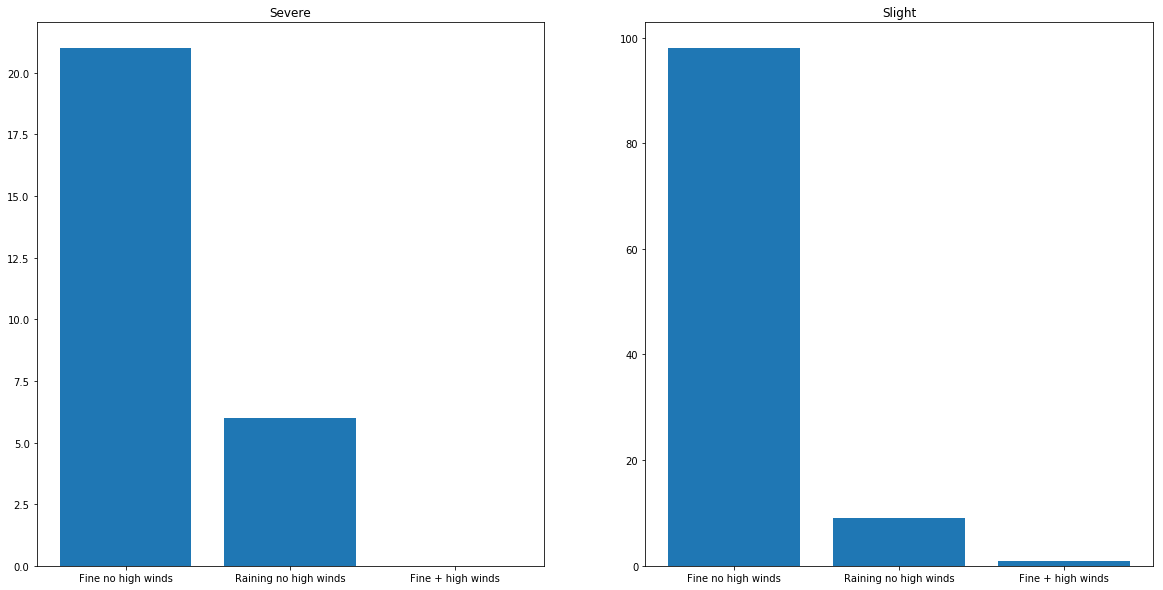

In [119]:
# Plot results
d_ser = w_dict["Serious"]
d_sli = w_dict["Slight"]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

plt.figure()
# One subplot for each type

plt.subplot(121)
plt.title("Severe")
plt.bar(range(len(d_ser)), list(d_ser.values()), align='center')
plt.xticks(range(len(d_ser)), list(d_ser.keys()))

plt.subplot(122)
plt.title("Slight")
plt.bar(range(len(d_sli)), list(d_sli.values()), align='center')
plt.xticks(range(len(d_sli)), list(d_sli.keys()))

plt.show()

### Hypothesis testing
$H_0$: Prop(bad, sserious) = Prop(bad, slight)

ie. that the proportion of serious accidents that happen in bad weather (anything that is not 'fine no high winds') is equal to the proportion for slight accidents


$H_1$: Prop(bad, serious) > Prop(bad, slight)

ie. that for serious the proportion is greater

For a p-value of 0.05.

In [149]:
# All serious
acc_ser = accidents[(accidents["Accident_Severity"] == "Serious")]
ser_list = list(acc_ser.Weather_Conditions.replace("Fine no high winds", 
                                   0).replace("Raining no high winds", 
                                              1).replace("Fine + high winds", 
                                                         1))

In [150]:
# All slight
acc_sli = accidents[(accidents["Accident_Severity"] == "Slight")]
sli_list = list(acc_sli.Weather_Conditions.replace("Fine no high winds", 
                                   0).replace("Raining no high winds", 
                                              1).replace("Fine + high winds", 
                                                         1))

In [151]:
# Hypothesis test: using t-test
from scipy.stats import ttest_ind
ttest_ind(ser_list, sli_list)

Ttest_indResult(statistic=1.874355235052793, pvalue=0.063075050407840505)

Conclusion: p > 0.05, so we cannot reject the null hypothesis.

## 2: Time of day
We bin into the following categories:

(12AM, 6AM] - early morning

(6AM, 10AM] - morning rush hour

(10AM, 3PM] - afternoon

(3PM, 7PM] - evening rush hour

(7PM, 12PM] - late night

In [175]:
acc_ser = accidents[(accidents["Accident_Severity"] == "Serious")]

acc_ser.Time = acc_ser.Time.map(lambda x: hour_x(x))

/usr/lib64/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [169]:
import datetime

def hour_x(x):
    time_x = datetime.datetime.strptime(x, '%H:%M').time()
    hour_x = time_x.hour
    return hour_x



In [192]:
bins = [6, 10, 15, 19, 24]
binned = list(pandas.cut(acc_ser['Time'], bins))